<a href="https://colab.research.google.com/github/harshith7823/CS760-Project/blob/main/part-2/Closest%20point/part2_model_based_knn_filled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, ElasticNetCV,RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [13]:
oppScrData = pd.read_excel(r'sample_data/OppScrData.xlsx')

In [22]:
def preprocess_clinical_data(oppScrData, mean=True):
    
    l = ['Record ID', 'BMI','BMI >30', 'Sex', 'Tobacco', 'Met Sx', 'Age at CT', 
          'Clinical F/U interval  [d from CT]', 'FRS 10-year risk (%)',
         'FRAX 10y Fx Prob (Orange-w/ DXA)', 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)',
         'CVD DX', 'Heart failure DX',
                                       'MI DX','Type 2 Diabetes DX', 'Primary Cancer Site', 'Humerus fracture DX',
                                       'Femoral neck fracture DX', 'Unspec femoral fracture DX', 'Forearm fracture DX'
                                       ,'Primary Cancer Site 2','Pathologic fracture DX','DEATH [d from CT]']

    clinical_data = oppScrData.filter(l, axis=1)
    # Replace all _,X,blanks with nan
    clinical_data = clinical_data.replace(r'_', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'X', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'^\s*$', np.nan, regex=True)

    # Fill na in bmi column with mean
    clinical_data['BMI'].fillna(value=clinical_data['BMI'].mean(skipna=True), inplace=True)
    
    # Fill na in bmi>30 column based on bmi col
    clinical_data.loc[clinical_data.BMI>30, 'BMI >30'] = 1
    clinical_data.loc[clinical_data.BMI<=30, 'BMI >30'] = -1
    
    clinical_data['Sex'] = np.where(clinical_data['Sex']=='Male',1,-1)
    clinical_data['Met Sx'] = np.where(clinical_data['Met Sx']=='Y',1,-1) 

    # Treat no data in tobacco as no tobacco usage
    clinical_data['Tobacco'] = np.where(clinical_data['Tobacco']=='Yes',1,-1) 


    clinical_data['FRS 10-year risk (%)'] = clinical_data['FRS 10-year risk (%)'].replace("<1", 0.01, regex=True)
    clinical_data['FRS 10-year risk (%)'] = clinical_data['FRS 10-year risk (%)'].replace(">30", 0.30, regex=True)
    clinical_data['FRS 10-year risk (%)'] =  clinical_data['FRS 10-year risk (%)'] * 100
    
    cols_to_be_filled = ['FRAX 10y Fx Prob (Orange-w/ DXA)','FRAX 10y Hip Fx Prob (Orange-w/ DXA)', 'FRS 10-year risk (%)']
    for c in cols_to_be_filled:
      if mean:  
        clinical_data[c].fillna(value=clinical_data[c].mean(skipna=True), inplace=True)
      else :
        clinical_data[c].fillna(value=clinical_data[c].median(skipna=True), inplace=True)

    for col in l[l.index('CVD DX'):l.index('DEATH [d from CT]')]:      
      clinical_data.loc[clinical_data[col].notna(), col] = 1
      clinical_data[col].fillna(value=0, inplace=True)
  
    return [clinical_data, np.array(clinical_data, dtype=np.float32)]

In [4]:
def clean_ct_data(oppScrData):
    # Delete rows with empty values
    ct_data= oppScrData[["Record ID", "L1_HU_BMD", "TAT Area (cm2)", 'Total Body                Area EA (cm2)',
       'VAT Area (cm2)', 'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)']]
    ct_data['Liver HU    (Median)'].replace(' ', np.nan, inplace=True)
    ct_data.dropna(axis = 0, how ='any', thresh = None, subset = None, inplace=True)
    return [ct_data, np.array(ct_data, dtype=np.float32)]

In [ ]:
sc = StandardScaler()
ct_data, ct_data_np = clean_ct_data(oppScrData=oppScrData)
clinical_data, clinical_data_np = preprocess_clinical_data(oppScrData)

In [130]:
combined_data_with_frx_and_fu = ct_data.merge(clinical_data, on='Record ID', how='inner' )
combined_data_with_frx_and_fu.drop(columns = ['Record ID'], inplace=True)
print(combined_data_with_frx_and_fu.columns)
print(combined_data_with_frx_and_fu.shape)

Index(['L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'BMI', 'BMI >30', 'Sex', 'Tobacco', 'Met Sx',
       'Age at CT', 'Clinical F/U interval  [d from CT]',
       'FRS 10-year risk (%)', 'FRAX 10y Fx Prob (Orange-w/ DXA)',
       'FRAX 10y Hip Fx Prob (Orange-w/ DXA)', 'CVD DX', 'Heart failure DX',
       'MI DX', 'Type 2 Diabetes DX', 'Primary Cancer Site',
       'Humerus fracture DX', 'Femoral neck fracture DX',
       'Unspec femoral fracture DX', 'Forearm fracture DX',
       'Primary Cancer Site 2', 'Pathologic fracture DX', 'DEATH [d from CT]'],
      dtype='object')
(8878, 33)


In [131]:
frx_fu_cols = ['Clinical F/U interval  [d from CT]',
       'FRS 10-year risk (%)', 'FRAX 10y Fx Prob (Orange-w/ DXA)']

clinical_outcome_cols = ['CVD DX',
       'Heart failure DX', 'MI DX', 'Type 2 Diabetes DX',
       'Primary Cancer Site', 'Humerus fracture DX',
       'Femoral neck fracture DX', 'Unspec femoral fracture DX',
       'Forearm fracture DX', 'Primary Cancer Site 2',
       'Pathologic fracture DX']
       
combined_data = combined_data_with_frx_and_fu.drop(columns = frx_fu_cols)

non_null_death_rows = combined_data[~combined_data['DEATH [d from CT]'].isnull()]
print(non_null_death_rows.shape)

(493, 30)


In [132]:
# Convert to years
non_null_death_rows['DEATH [d from CT]'] /= 365

m = non_null_death_rows.columns.get_loc('DEATH [d from CT]')

X = non_null_death_rows.iloc[:, 0:m]
y = non_null_death_rows.iloc[:, m]
X = pd.DataFrame(sc.fit_transform(X), columns = X.columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
def print_error(y_pred, y_test):
  print(f'MAE = {mean_absolute_error(y_pred, y_test)}')
  print(f'MAPE = {mean_absolute_percentage_error(y_pred, y_test)}')
  print(f'RMSE = {mean_squared_error(y_pred, y_test)**0.5}')

In [140]:
def testWithModel(model, X_train, X_test, y_train, y_test, z=15):
  clf = model
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  age = X_test['Age at CT']
  print_error(y_pred, y_test)
  plot_results(y_pred + age, y_test + age, z)

  return y_pred

In [87]:
def plot_results(y_pred, y_test, z=15):
  plt.figure()
  y_test_sub, y_pred_sub = y_test, y_pred
  if len(y_test)>200:
    y_test_sub, y_pred_sub = y_test[::z], y_pred[::z]
    
  x = [i+1 for i in range(len(y_test_sub))]
  plt.plot((x,x),([i for i in y_pred_sub], [j for j in y_test_sub]),c='green',markevery=5,)
  plt.scatter(x, y_pred_sub, label="Predicted age at death")
  plt.scatter(x, y_test_sub, label="Actual age at death")
  plt.xlabel("Patient record")
  plt.ylabel("Years")
  plt.legend()
  plt.show()

Train

In [134]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)

knn = KNeighborsRegressor()
param_grid2 = dict(weights = ["uniform", "distance"], n_neighbors=list(range(2, 17)))
    
grid = GridSearchCV(knn, param_grid2)
grid.fit(X_train, y_train)
p3 = grid.predict(X_test)
print_error(p3, y_test)
print(grid.best_params_)

MAE = 2.945190086531984
MAPE = 0.45515703291944065
RMSE = 3.4478395336450625
{'n_neighbors': 16, 'weights': 'distance'}


In [ ]:
for idx, row in combined_data.iterrows():  
  if np.isnan(combined_data.at[idx,'DEATH [d from CT]']):
    l = combined_data.columns.drop('DEATH [d from CT]')
    row = combined_data.iloc[idx].drop(columns = ['DEATH [d from CT]'], inplace=True)    
    row = combined_data.iloc[idx]     
    r = row.filter(l).to_numpy().reshape(1, -1) 
    combined_data.at[idx,'DEATH [d from CT]'] = (grid.predict(r))
  else:
    combined_data.at[idx,'DEATH [d from CT]'] /= 365

**Cleaning combined data to only comprise of ct+clinical data (removing clinical outcomes)**

In [136]:
combined_data.drop(columns=clinical_outcome_cols, inplace=True)
for col in frx_fu_cols:
  combined_data[col] = combined_data_with_frx_and_fu[col]

print(combined_data.columns)

Index(['L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'BMI', 'BMI >30', 'Sex', 'Tobacco', 'Met Sx',
       'Age at CT', 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)',
       'DEATH [d from CT]', 'Clinical F/U interval  [d from CT]',
       'FRS 10-year risk (%)', 'FRAX 10y Fx Prob (Orange-w/ DXA)'],
      dtype='object')


In [137]:
m = combined_data.columns.get_loc('DEATH [d from CT]')
y = combined_data.iloc[:,m]
X = combined_data.iloc[:, 0:m]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)

In [138]:
print(X_train.shape)
print(X_test.shape)
print(X_train.columns)

(7102, 18)
(1776, 18)
Index(['L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'BMI', 'BMI >30', 'Sex', 'Tobacco', 'Met Sx',
       'Age at CT', 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)'],
      dtype='object')


MAE = 0.4845566216902358
MAPE = 0.08099553253696608
RMSE = 1.0477962329492396


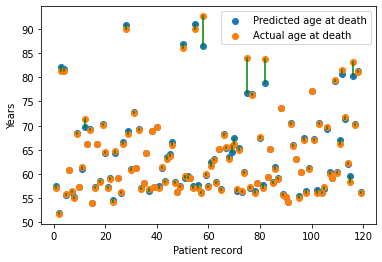

In [141]:
svr_pred = testWithModel(SVR(C=300, epsilon=0.8),X_train, X_test, y_train, y_test)

MAE = 0.39392973221307204
MAPE = 0.06612461612025378
RMSE = 1.0195327541341723


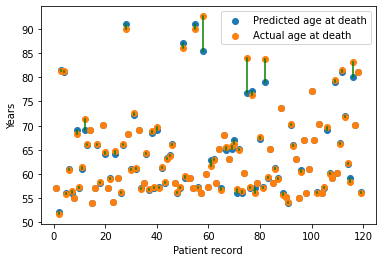

In [142]:
lasso_pred = testWithModel(Lasso(alpha=0.1), X_train, X_test, y_train, y_test)

MAE = 0.39395491560707635
MAPE = 0.06609734163696844
RMSE = 1.0211441834536392


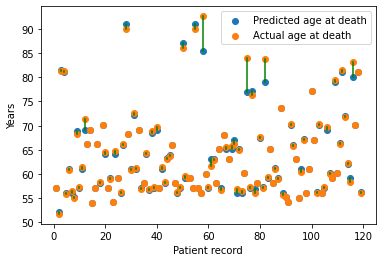

In [143]:
elastic_net_pred = testWithModel(ElasticNetCV(random_state=0), X_train, X_test, y_train, y_test)

MAE = 0.5035155701132741
MAPE = 0.2629856660073194
RMSE = 1.3980108891829988


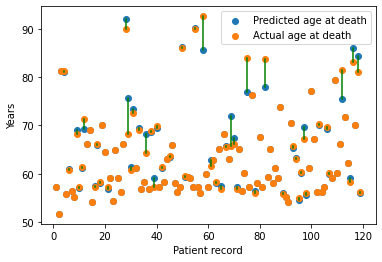

In [144]:
dtree_pred = testWithModel(DecisionTreeRegressor(criterion="absolute_error"),X_train, X_test, y_train, y_test)

MAE = 0.35386104572849025
MAPE = 0.05996052123441404
RMSE = 0.9987733663675453


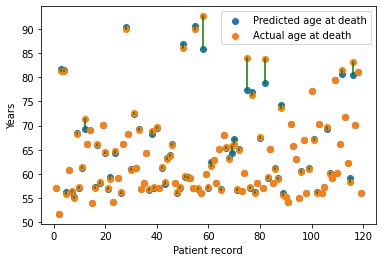

In [145]:
RFparams2={'n_estimators':[70],
          'min_samples_split':[20],
          'min_samples_leaf': [4],
           'max_features': [18],
           'max_depth': [15],
           'bootstrap': [True]}

rf = RandomForestRegressor(random_state = 21)
clf_random_forest = GridSearchCV(rf, RFparams2, refit=True)

rf_pred = testWithModel(clf_random_forest ,X_train, X_test, y_train, y_test )

Build Ensemble


In [146]:
array_preds = np.array([elastic_net_pred, svr_pred, lasso_pred, dtree_pred, rf_pred])

Avg of all preds

In [147]:
y_ens_avg = np.mean((array_preds), axis=0 )

In [157]:
print(y_ens_avg.shape)
print(X_test.shape)
age = X_test['Age at CT']
print(age.shape)

(1776,)
(1776, 18)
(1776,)


MAE = 0.38617733842170004
MAPE = 0.06504385374240837
RMSE = 1.0195370506497274


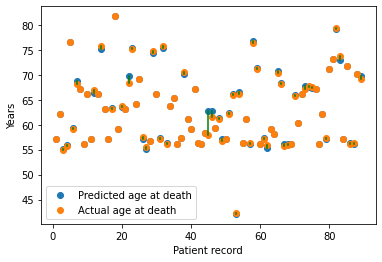

In [158]:
print_error(y_ens_avg, y_test)
plot_results(y_ens_avg + age , y_test + age, 20)

Randomly pick a prediction

In [159]:
import random
y_ens=[]

for i,y in enumerate(y_test):

  j = random.randint(0, 4)
  y_ens.append( array_preds[j][i])

MAE = 0.43350128734573407
MAPE = 0.21848514173027475
RMSE = 1.1047722383281962


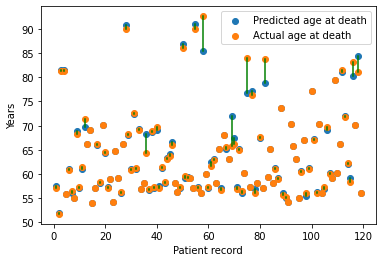

In [160]:
print_error(y_ens, y_test)
plot_results(y_ens + age, y_test + age)

Ensemble with Linear Regression

In [161]:
preds_transpose = array_preds.T

In [163]:
X_train_ens, X_test_ens, y_train_ens, y_test_ens  = train_test_split(preds_transpose, y_test, test_size=0.2, random_state=0)

In [164]:
lin_reg = LinearRegression().fit(X_train_ens, y_train_ens)
lin_reg.score(X_test_ens, y_test_ens)

0.07893311443808793

In [165]:
print(lin_reg.coef_)
print(lin_reg.intercept_)

[-3.81373449 -0.03547652  3.57083639 -0.01656541  0.84665327]
2.767607400442187


In [166]:
y_pred_ens=lin_reg.predict(X_test_ens)

In [167]:
print(len(y_pred_ens))

356


***The graph below only denotes the difference in the predicted age at death and the actual age at death - Please note this must be added to age at CT. Since the test train split is only on outputs from other models, we cannot map the corresponding Age_at_CT to plot on the graph below ***

MAE = 0.4276214736173781
MAPE = 0.07114875631048713
RMSE = 1.08321202615583


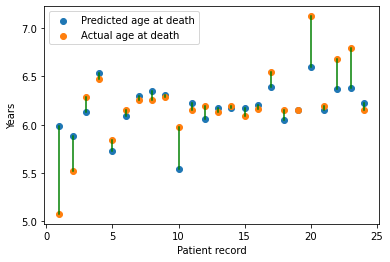

In [168]:
print_error(y_pred_ens, y_test_ens)
plot_results(y_pred_ens , y_test_ens)